
**EDA** (Exploratory Data Analysis).<P>
The purpose of EDA is:
+ Look at the data
+ Understand the distribution of two classes (hasn't cactus / has cactus)
+ Look at some features of the image (distribution of RGB channels, average brightness, etc.)

In [1]:
# Libreries

import numpy as np
import pandas as pd
import os

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data path
labels = pd.read_csv('../input/train.csv')
sub = pd.read_csv('../input/sample_submission.csv')
train_path = '../input/train/train/'
test_path = '../input/test/test/'


In [3]:
print('Num train samples:{0}'.format(len(os.listdir(train_path))))
print('Num test samples:{0}'.format(len(os.listdir(test_path))))

Num train samples:17500
Num test samples:4000


In [4]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

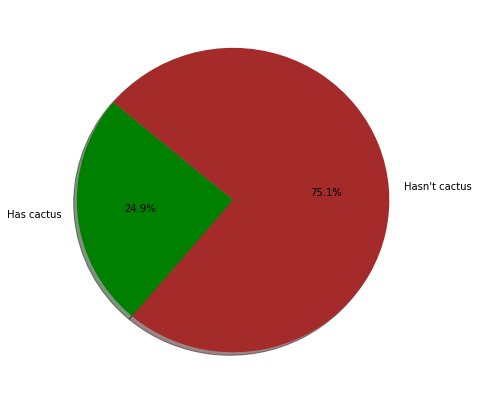

In [6]:
lab = 'Has cactus','Hasn\'t cactus'
colors=['green','brown']

plt.figure(figsize=(7,7))
plt.pie(labels.groupby('has_cactus').size(), labels=lab,
        labeldistance=1.1, autopct='%1.1f%%',
        colors=colors,shadow=True, startangle=140)
plt.show()

** Has cactus**

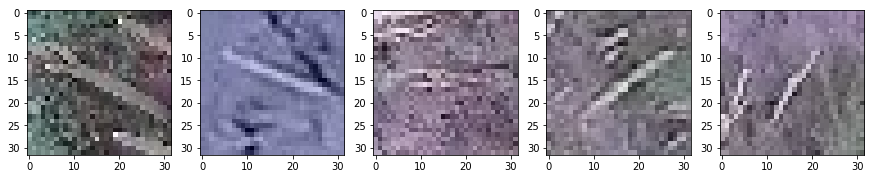

In [7]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

**Hasn't cactus**

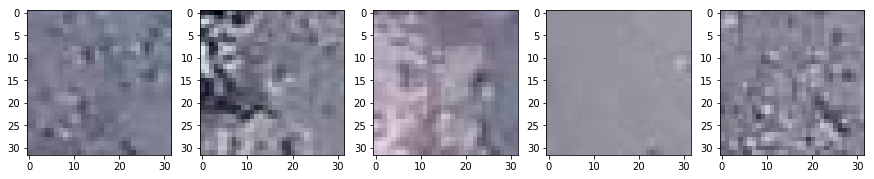

In [8]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

**convolutional neural network on pytorch from scratch**

In [9]:
# Libreries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [10]:
## Parameters for model

# Hyper parameters
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
# data splitting
train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)
train.shape, val.shape

((15750, 2), (1750, 2))

Checking label distribution(must be 1:3)

In [12]:
train['has_cactus'].value_counts()

1    11822
0     3928
Name: has_cactus, dtype: int64

In [13]:
val['has_cactus'].value_counts()

1    1314
0     436
Name: has_cactus, dtype: int64

**Simple custom generator**

In [14]:
# NOTE: class is inherited from Dataset
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [15]:
# Image preprocessing
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Data generators
dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

**Model**

In [16]:
# NOTE: class is inherited from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

**Important note:** You may notice that in lines with # !!! there is not very clear 128 \* 11 \* 11. This is the dimension of the picture before the FC layers (H x W x C), then you have to calculate it manually (in Keras, for example, .Flatten () does everything for you). However, there is one life hack — just make print (x.shape) in forward () (commented out line). You will see the size (batch_size, C, H, W) - you need to multiply everything except the first (batch_size), this will be the first dimension of Linear (), and it is in C H W that you need to "expand" x before feeding to Linear ().

In [17]:
model = SimpleCNN().to(device)

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [19]:

# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/25], Step [100/124], Loss: 0.0584
Epoch [2/25], Step [100/124], Loss: 0.0095
Epoch [3/25], Step [100/124], Loss: 0.0156
Epoch [4/25], Step [100/124], Loss: 0.0050
Epoch [5/25], Step [100/124], Loss: 0.0051
Epoch [6/25], Step [100/124], Loss: 0.0047
Epoch [7/25], Step [100/124], Loss: 0.0112
Epoch [8/25], Step [100/124], Loss: 0.0156
Epoch [9/25], Step [100/124], Loss: 0.0078
Epoch [10/25], Step [100/124], Loss: 0.0294
Epoch [11/25], Step [100/124], Loss: 0.0055
Epoch [12/25], Step [100/124], Loss: 0.0600
Epoch [13/25], Step [100/124], Loss: 0.0016
Epoch [14/25], Step [100/124], Loss: 0.0073
Epoch [15/25], Step [100/124], Loss: 0.0053
Epoch [16/25], Step [100/124], Loss: 0.0014
Epoch [17/25], Step [100/124], Loss: 0.0036
Epoch [18/25], Step [100/124], Loss: 0.0011
Epoch [19/25], Step [100/124], Loss: 0.0030
Epoch [20/25], Step [100/124], Loss: 0.0025
Epoch [21/25], Step [100/124], Loss: 0.0012
Epoch [22/25], Step [100/124], Loss: 0.0034
Epoch [23/25], Step [100/124], Loss: 0.00

**Accuracy Check**

In [20]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 1750 validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 1750 validation images: 99.25714285714285 %


**CSV submission**

In [21]:
# generator for test data 
dataset_valid = MyDataset(df_data=sub, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [22]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

sub['has_cactus'] = preds
sub.to_csv('sub.csv', index=False)